# **Video processing**

## Video importing and *причесывание*

Importing the video from **my** google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the video from somebody's google srive

In [ ]:
# https://drive.google.com/file/d/1olPiH_AMXrbLM8-isv35ZV2GdBeH4Hk9/view?usp=drivesdk

file_id = "1olPiH_AMXrbLM8-isv35ZV2GdBeH4Hk9"
destination = "video.mp4"

import gdown
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

# Check if the file is saved
import os
if os.path.exists(destination):
    print(f"File '{destination}' has been saved successfully!")
else:
    print("File download failed.")

Downloading...
From (original): https://drive.google.com/uc?id=1olPiH_AMXrbLM8-isv35ZV2GdBeH4Hk9
From (redirected): https://drive.google.com/uc?id=1olPiH_AMXrbLM8-isv35ZV2GdBeH4Hk9&confirm=t&uuid=bde94332-d8cc-48b8-bde5-6a27d2d2e5a6
To: /content/video.mp4
  9%|▉         | 268M/2.97G [00:03<00:38, 70.7MB/s]

KeyboardInterrupt: 

Functions for formating the image

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Gaussian noise
# def add_noise(image, kwards):
#     noisy_image = image.copy()
#     mean = kwargs.get("mean", 0)
#     std_dev = kwargs.get("std_dev", 20)
#     gaussian_noise = np.random.normal(mean, std_dev, image.shape).astype(np.int16)
#     noisy_image = cv2.add(image.astype(np.int16), gaussian_noise)
#     noisy_image = np.clip(noisy_image, 0, 100).astype(np.uint8)
#     return noisy_image

def compress_and_increase_contrast(image, resize_factor, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Resizes the image to the target size and enhances contrast.

    Args:
        image (numpy.ndarray): Input image in OpenCV format (BGR or grayscale).
        target_size (tuple): Desired size for resizing (width, height).
        clip_limit (float): Contrast limit for CLAHE (higher values mean more contrast).
        tile_grid_size (tuple): Grid size for CLAHE (smaller grids mean more localized contrast).
    """
    # Resize the image
    image_size = image.shape
    target_size = (resize_factor*image_size[1], resize_factor*image_size[0])
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    # Check if the image is grayscale or color
    if len(resized_image.shape) == 2:  # Grayscale image
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        enhanced_image = clahe.apply(resized_image)
    else:  # Color image (BGR)
        # Convert to LAB color space
        lab = cv2.cvtColor(resized_image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE on the L (lightness) channel
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        l_enhanced = clahe.apply(l)

        # Merge the channels back and convert to BGR
        lab_enhanced = cv2.merge((l_enhanced, a, b))
        enhanced_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    return enhanced_image

def reduce_tones(image, n_tones=4):
    """
    Reduces the image to n tones by quantizing pixel values.

    Args:
        image (numpy.ndarray): Input image (grayscale or BGR).
        n_tones (int): Number of tones to reduce the image to (e.g., 2, 4, 8).

    Returns:
        numpy.ndarray: Image with reduced tones.
    """
    if n_tones < 2:
        raise ValueError("Number of tones must be at least 2.")

    # Determine the quantization step size
    step = 256 // n_tones

    # Apply quantization
    quantized_image = (image // step) * step

    return quantized_image

def increase_exposure(image, factor=1.5):
    """
    Increases the exposure (brightness) of an image by a given factor.

    Args:
        image (numpy.ndarray): Input image (grayscale or BGR).
        factor (float): Exposure multiplier (e.g., 1.5 for 50% brighter).

    Returns:
        numpy.ndarray: Image with increased exposure.
    """
    # Ensure the factor is positive
    if factor <= 0:
        raise ValueError("Exposure factor must be greater than 0.")

    # Increase exposure by multiplying pixel values
    # Clip values to ensure they remain within valid range [0, 255]
    exposed_image = np.clip(image * factor, 0, 255).astype(np.uint8)

    return exposed_image

def cropping(frame, grnd):
  return frame[grnd[2]:grnd[3], grnd[0]:grnd[1]]

def rotating(frame, angle):
  width, height = frame.shape[:2]
  R = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
  rotated_img = cv2.warpAffine(frame, R, (height, width), borderMode=cv2.BORDER_CONSTANT, borderValue=(240,240,240))
  return rotated_img

Compressing the video (there was a huge video and my notebook давеча приказал долго жить, so I've been trying to comress it without downloading)

In [88]:
from moviepy.video.io.VideoFileClip import VideoFileClip

from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.fx.all import resize  # Import the resize effect

def compress_video(input_path, output_path, target_resolution=(1280, 720), bitrate="1M"):
    """
    Compress and resize a video using moviepy.

    Args:
        input_path (str): Path to the input video.
        output_path (str): Path to save the compressed video.
        target_resolution (tuple): Desired resolution (width, height).
        bitrate (str): Target bitrate for the output file (e.g., "1M" for 1 Mbps).
    """
    # Load the video
    video = VideoFileClip(input_path)

    # Apply resizing
    video_resized = resize(video, height=target_resolution[1])  # Resize by height

    # Write the output video with lower bitrate
    video_resized.write_videofile(
        output_path,
        bitrate=bitrate,
        codec="libx264",  # H.264 codec for compression
        audio_codec="aac",  # AAC audio codec
        threads=4  # Multithreaded processing for speed
    )

# Example usage
input_video = "video.mp4"
output_video = "compressed_video.mp4"
compress_video(input_video, output_video, target_resolution=(640, 360), bitrate="1M")

OSError: MoviePy error: the file video.mp4 could not be found!
Please check that you entered the correct path.

Reading video

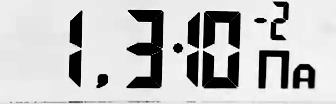

In [16]:
# a complex filter for each frame
def filter(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  # frame = compress_and_increase_contrast(frame, 1, 10.0, (20, 20))
  frame = increase_exposure(frame, 1.9)
  frame = reduce_tones(frame, 100)

  # frame = cropping(frame, (300, 650, 310, 410))

  return frame

def video_read(video_path):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
        print("Error: Could not open video.")
        return None
  return cap

video = video_read('/content/drive/MyDrive/lab/last_meas_pressure.mp4')

fps = int(video.get(cv2.CAP_PROP_FPS))

success, frame = video.read()
frame = filter(frame)
frames = [frame]

i = 2
while success:
  success, frame  = video.read()
  if i%10 == 0:
    # frame = cv2.GaussianBlur(frame, (9, 9), 0)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = filter(frame)
    frames.append(frame)
  i+=1
video.release()

#making digits black
img_to_neg = lambda x: 255 - x
frames = list(map(img_to_neg, frames))

# Showing a test frame
cv2_imshow(frames[-1])

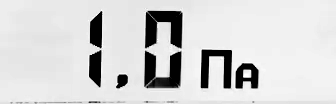

In [17]:
cv2_imshow(frames[97])

## Preparing the data for a model

There're frames of three types: '10 Pa', '1,0 Pa' and '1,0*10^-1 Pa'. So I cut the frames by the respecting groups

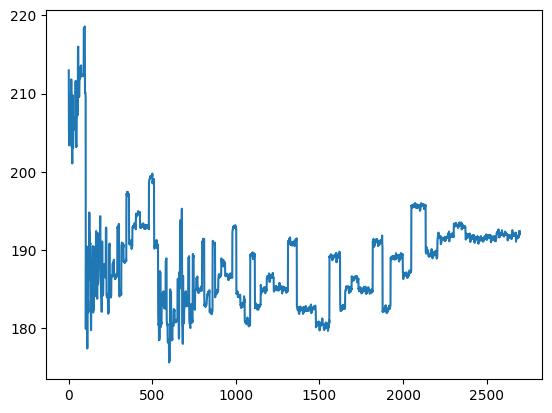

In [18]:
# the mean intensity. Sometimes it helps to find the boundaries

intensity = list(map(lambda x: x.mean(), frames))

import matplotlib.pyplot as plt
plt.plot(intensity)
plt.show()

Here I перебираю the frames, looking for the boundaries

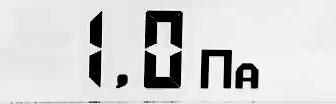

In [39]:
n_start = 0
n_bound_1 = 0
n_bound_2 = 102
cv2_imshow(frames[101]) #after the 513st frame, the exp part appears

Cutting

In [40]:
part_1 = frames[n_start:n_bound_1]
part_2 = frames[n_bound_1:n_bound_2]
part_3 = frames[n_bound_2:]

Cropping the digits

part_1

In [42]:
digit_11 = (60, 110, 0, 100) #x_min, x_max, y_min, y_max
digit_12 = (140, 190, 0, 100) #x_min, x_max, y_min, y_max

# indicator_4 = cropping(part_1[2], digit_11)
# indicator_4 = rotating(indicator_4, 1)

# indicator_1 = cropping(part_1[2], digit_12)
# indicator_1 = rotating(indicator_1, 1)

# cv2_imshow(indicator_4)
# cv2_imshow(indicator_1)

part_2

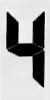

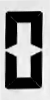

In [43]:
digit_21 = (60, 110, 0, 100) #x_min, x_max, y_min, y_max
digit_22 = (140, 190, 0, 100) #x_min, x_max, y_min, y_max

indicator_4 = cropping(part_2[0], digit_21)
indicator_4 = rotating(indicator_4, 1)

indicator_1 = cropping(part_2[2], digit_22)
indicator_1 = rotating(indicator_1, 1)

cv2_imshow(indicator_4)
cv2_imshow(indicator_1)

part_3

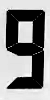

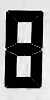

In [61]:
digit_31 = (40, 90, 0, 100) #x_min, x_max, y_min, y_max
digit_32 = (120, 170, 0, 100) #x_min, x_max, y_min, y_max
digit_33 = (268, 290, 0, 45) #x_min, x_max, y_min, y_max

indicator_9 = cropping(part_3[0], digit_31)
indicator_8 = cropping(part_3[0], digit_32)
indicator_11 = cropping(part_3[-1], digit_33)

cv2_imshow(indicator_9)
cv2_imshow(indicator_8)
cv2_imshow(indicator_11)

# **The model**

## Grabbing a dataset from a video. It shows a random digit from some real data and then I tell him which exactly it was

In [63]:
import cv2
import pandas as pd
import base64
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from random import sample

# Function to encode OpenCV image as Base64
def encode_image_to_base64(image):
    _, buffer = cv2.imencode('.png', image)
    return base64.b64encode(buffer).decode('utf-8')

# Function to display a single image using Matplotlib
def show_image_colab(image, current_idx, total_frames):
    plt.imshow(image, cmap='gray')
    plt.title(f"Frame {current_idx + 1}/{total_frames}")
    plt.axis('off')
    plt.show()

# Interactive labeling function with Enter key support
def interactive_labeling(frames, quit_key="q"):
    """
    Display frames one by one and allow the user to enter the recognized digit
    using a text box widget. Confirm input using the Enter key.
    """
    results = []
    frame_idx = 0
    total_frames = len(frames)

    # Text box for user input
    input_box = widgets.Text(
        placeholder=f"Enter recognized digit or '{quit_key}' to quit",
        description="Digit:",
        disabled=False
    )

    # Output widget to display frames
    output = widgets.Output()

    def display_frame():
        with output:
            clear_output(wait=True)
            show_image_colab(frames[frame_idx], frame_idx, total_frames)

    def process_input(value):
        nonlocal frame_idx

        recognized_digit = value.strip()
        if recognized_digit == quit_key:
            print("Quitting early. Saving results...")
            save_results()
            return

        # Validate input (allow digits, floats, and the quit key)
        if not recognized_digit.isdigit() and not (',' in recognized_digit or '.' in recognized_digit):
            print("Invalid input! Please enter a valid number.")
            return

        # Encode image and store result
        encoded_image = encode_image_to_base64(frames[frame_idx])
        results.append((recognized_digit, encoded_image))

        # Move to the next frame
        frame_idx += 1
        if frame_idx < total_frames:
            input_box.value = ""  # Clear the input box
            display_frame()
        else:
            print("All frames processed!")
            input_box.disabled = True
            save_results()

    def save_results():
        # Save results to a CSV file
        df = pd.DataFrame(results, columns=["Digit", "Image_Base64"])
        output_file = "labeled_digits_table.csv"
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
        display(df)

    # Event listener: Process input when Enter key is pressed
    def on_enter(change):
        if change["name"] == "value" and change["new"]:  # Detect change
            process_input(change["new"])

    # Attach the event listener
    input_box.observe(on_enter)

    # Display the first frame and the text input
    display_frame()
    display(input_box, output)

def example_frames(part, scaling, angle):
  scale_x = lambda x: cropping(x, scaling)
  rotate_x = lambda x: rotating(x, angle)
  return list(map(rotate_x, map(scale_x, part)))

# Example Usage
if __name__ == "__main__":
    # Generate sample frames (replace with your own list of OpenCV images)
    # samples_1 = sample(part_1, len(part_1))
    samples_2 = sample(part_3, len(part_3))
    example_frames = example_frames(samples_2, digit_32, 1)
    # example_frames = example_frames(samples_1, digit_12, 1) + example_frames(samples_2, digit_22, 1)
    # Run the interactive labeling process
    interactive_labeling(example_frames, quit_key="q")


Text(value='', description='Digit:', placeholder="Enter recognized digit or 'q' to quit")

Output()

Quitting early. Saving results...
Results saved to labeled_digits_table.csv


,Digit,Image_Base64
0,2,iVBORw0KGgoAAAANSUhEUgAAADIAAABkCAAAAADhgzyHAA...
1,9,iVBORw0KGgoAAAANSUhEUgAAADIAAABkCAAAAADhgzyHAA...
2,0,iVBORw0KGgoAAAANSUhEUgAAADIAAABkCAAAAADhgzyHAA...
3,3,iVBORw0KGgoAAAANSUhEUgAAADIAAABkCAAAAADhgzyHAA...
4,9,iVBORw0KGgoAAAANSUhEUgAAADIAAABkCAAAAADhgzyHAA...
5,4,iVBORw0KGgoAAAANSUhEUgAAADIAAABkCAAAAADhgzyHAA...
6,7,iVBORw0KGgoAAAANSUhEUgAAADIAAABkCAAAAADhgzyHAA...


## Training and testing the model

The model

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import base64
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

s = 28

# Custom Dataset Class
class DigitDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.images = []
        self.labels = []

        # Decode images and store them as NumPy arrays
        for idx, row in self.data.iterrows():
            img_base64 = row["Image_Base64"]
            img_data = base64.b64decode(img_base64)
            img_np = np.frombuffer(img_data, dtype=np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (s, s))  # Resize to 28x28
            self.images.append(img_resized.flatten())  # Flatten for logistic regression
            self.labels.append(row["Digit"])

        # Convert images and labels to tensors
        self.images = torch.tensor(self.images, dtype=torch.float32) / 255.0  # Normalize
        self.labels = torch.tensor(LabelEncoder().fit_transform(self.labels), dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)  # Linear layer

    def forward(self, x):
        return torch.softmax(self.linear(x), dim=1)  # Use softmax to get probabilities

# Function to train the model
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

# Function to evaluate the model and display probabilities
def evaluate_model(model, dataloader, class_names):
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            probabilities = outputs.numpy()
            predictions = np.argmax(probabilities, axis=1)
            for i in range(len(images)):
                plt.imshow(images[i].reshape(s, s), cmap="gray")
                plt.title(f"Predicted: {class_names[predictions[i]]}, Probability: {max(probabilities[i]):.2f}")
                plt.axis('off')
                plt.show()

# Main Execution
if __name__ == "__main__":
    # Path to the labeled dataset CSV file
    dataset_path = "labeled_digits_table.csv"  # Replace with your actual file path

    # Load dataset
    dataset = DigitDataset(dataset_path)
    train_data, test_data = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_subset = torch.utils.data.Subset(dataset, train_data)
    test_subset = torch.utils.data.Subset(dataset, test_data)

    # Dataloaders
    train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

    # Model Parameters
    input_size = s * s  # Flattened image size
    num_classes = len(set(dataset.labels.numpy()))  # Unique classes

    # Initialize model, loss function, and optimizer
    model = LogisticRegressionModel(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    print("Training the model...")
    train_model(model, train_loader, criterion, optimizer, epochs=20)

    # # Evaluate the model
    # print("\nEvaluating the model...")
    # class_names = list(set(dataset.data["Digit"]))  # Extract class names from the dataset
    # evaluate_model(model, test_loader, class_names)

    # Assuming your model is named 'model'
    model_path = "logistic_regression_model.pth"  # Path where you want to save the model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


Testing

In [65]:
import pandas as pd
import cv2
import numpy as np
import base64
from io import BytesIO

# Importing the model
model_path = "logistic_regression_model.pth"  # Path to the trained model
model = LogisticRegressionModel(input_size=28 * 28, num_classes=10)
model.load_state_dict(torch.load(model_path))


# Function to decode Base64 and convert it to OpenCV image
def decode_base64_image(base64_string):
    # Decode the Base64 string to bytes
    img_data = base64.b64decode(base64_string)

    # Convert byte data to numpy array
    np_arr = np.frombuffer(img_data, dtype=np.uint8)

    # Decode the numpy array into an image
    img = cv2.imdecode(np_arr, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
    return img

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('labeled_digits_table.csv')
df.columns = ['labels', 'images']

# Convert the 'images' column (Base64 encoded) to actual image data
df['images'] = df['images'].apply(decode_base64_image)

# # Now, the DataFrame has 'digits' as labels and 'images' as image data
labels = df['labels'].to_numpy()  # Convert 'digits' to NumPy array (labels)
images = np.array(df['images'].to_list())  # Convert 'images' column to NumPy array

# # Check the result
print("Dataframe loaded successfully!")
print(f"Labels: {labels[:5]}")  # Display the first few labels
print(f"Images: {images.shape}")  # Display the shape of the images array

<ipython-input-65-0c8080e76b5c>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Dataframe loaded successfully!
Labels: [1 6 8 7 2]
Images: (399, 200, 100)


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

# Function to predict the digit in an OpenCV grayscale image
def predict_digit(image, model=model, class_names=list(range(10))):
    model.eval()  # Set model to evaluation mode

    # Preprocess the image
    image_resized = cv2.resize(image, (28, 28))
    image_flattened = image_resized.flatten().astype(np.float32) / 255.0  # Normalize
    image_tensor = torch.tensor(image_flattened, dtype=torch.float32).unsqueeze(0)

    # Perform prediction
    with torch.no_grad():
        outputs = model(image_tensor)  # Forward pass
        probabilities = torch.softmax(outputs, dim=1).numpy()[0]  # Apply softmax
        predicted_index = np.argmax(probabilities)
        predicted_digit = class_names[predicted_index]
        predicted_probability = probabilities[predicted_index]

    return predicted_digit, predicted_probability


# Function to test the model and display results horizontally
def test_model_on_dataset(images, labels, model, class_names, num_examples=5):
    correct = 0  # Counter for correct predictions
    total = len(images)

    plt.figure(figsize=(15, 3))  # Set up horizontal figure

    for i in range(num_examples):
        image = images[i]
        true_label = labels[i]

        # Predict using the model
        predicted_digit, probability = predict_digit(image, model, class_names)

        # Check for accuracy
        if predicted_digit == true_label:
            correct += 1

        # Display the image and prediction
        # plt.subplot(1, num_examples, i + 1)
        # plt.imshow(image, cmap='gray')
        # plt.title(f"Pred: {predicted_digit}\nTrue: {true_label}\nProb: {probability:.2f}")
        # plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate and display accuracy
    accuracy = correct / num_examples * 100
    print(f"Test Accuracy on {num_examples} examples: {accuracy:.2f}%")


# # Example Usage
if __name__ == "__main__":
    # Load the trained model
    model_path = "logistic_regression_model.pth"  # Path to the trained model
    model = LogisticRegressionModel(input_size=28 * 28, num_classes=10)
    model.load_state_dict(torch.load(model_path))

    # Load dataset (example images and labels)
    images, labels = images, labels

    # Test the model and show results
    class_names = list(range(10))  # Digits 0-9
    test_model_on_dataset(images, labels, model, class_names, num_examples=100)

<ipython-input-66-e45b077719c0>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<Figure size 1500x300 with 0 Axes>

Test Accuracy on 100 examples: 100.00%


## Using the model

,time (s),pressure (Pa)
0,0.0,4.100
1,0.3,4.000
2,0.7,4.000
3,1.0,3.900
4,1.3,3.700
...,...,...
2694,898.0,0.013
2695,898.3,0.013
2696,898.7,0.013
2697,899.0,0.013


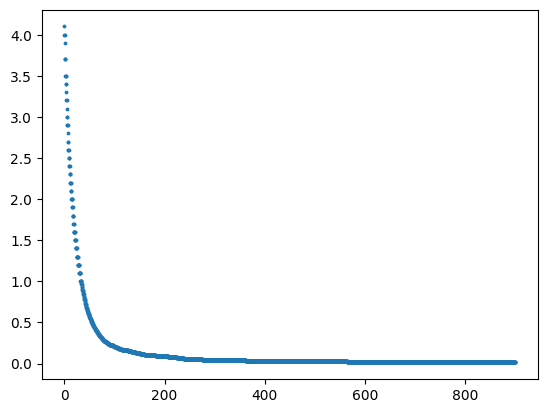

In [67]:
import pandas as pd

# def model_prediction(frame, model=model):
#   input_tensor = preprocess_opencv_image(frame)
#   digit, prob_tensor = predict_digit(input_tensor, model)
#   return digit

def reading(album, digit_coords_1, digit_coords_2, digit_coords_3=None):
  '''
  frames: list of frames
  digit_1, digit_2, digit_3: coordinates of the digit
  '''
  digits_1 = []
  digits_2 = []
  digits_3 = []
  model.eval()
  for fr in album:
    d_1 = cropping(fr, digit_coords_1)
    d_2 = cropping(fr, digit_coords_2)
    digits_1.append(predict_digit(d_1)[0])
    digits_2.append(predict_digit(d_2)[0])
    if digit_coords_3 != None:
      d_3 = cropping(fr, digit_coords_3)
      digits_3.append(predict_digit(d_3)[0])
    else:
      digits_3.append(0)
  df = pd.DataFrame(data={'d_1':digits_1, 'd_2':digits_2, 'd_3':digits_3})
  return df

df = pd.concat([reading(part_1, digit_11, digit_12),
                reading(part_2, digit_21, digit_22),
                reading(part_3, digit_31, digit_32, digit_33)],
               ignore_index=True)
# df.iloc[:, 2] = df.iloc[:, 2].apply(lambda x: x/x*4)
# df.iloc[576:693, 1] = df.iloc[576:693, 0].apply(lambda x: x-1)
number_deconstruct = lambda df: (abs(df['d_1']) + abs(df['d_2'])/10)/10**(abs(df['d_3']))

values = number_deconstruct(df)
time = np.round(10/fps*np.arange(len(values)), 1)

final_data = pd.DataFrame({'time (s)': time, 'pressure (Pa)': values})
final_data.to_csv('two_chambers_soviet_tv.csv', index=False)

plt.scatter(time, values, s=3)
# plt.plot(time, values)
# plt.ylim(0, 1)

# time

final_data

# **Some old code that has become useless while working, but may help in future**

## Training a special model

Dataset generation (creating an artificial dataset)

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import random
import os

# Function to generate a single image with a digit
def generate_image(number, font_path, image_size=(28, 28)):
    # Create a blank image
    img = Image.new('RGB', (100, 180), color='white')
    draw = ImageDraw.Draw(img)
    # Convert number to text
    text = f"{number:.1f}".replace('.', ', ') if isinstance(number, float) else str(number)
    # Load the font
    try:
        font = ImageFont.truetype(font_path, size=130)
    except Exception as e:
        print(f"Error loading font: {e}")
        return None
    # Center the text
    text_bbox = font.getbbox(text)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    text_x, text_y = (img.width - text_width) / 2, (img.height - text_height) / 2*0.2
    # Draw the text
    draw.text((text_x, text_y), text, font=font, fill="black")
    # Convert PIL image to grayscale NumPy array and resize to MNIST size
    img_np = np.array(img)
    img_blured = cv2.GaussianBlur(img_np, (13, 13), 0)
    img_noised = add_noise(img_blured)
    img_gray = cv2.cvtColor(img_noised, cv2.COLOR_RGB2GRAY)
    img_resized = cv2.resize(img_gray, image_size, interpolation=cv2.INTER_AREA)
    return img_resized

# Function to generate the dataset
def generate_dataset(font_path, num_samples=1000, image_size=(28, 28)):
    images = []
    labels = []

    for i in range(num_samples):
        # Randomly choose between a digit or a float
        # if random.random() > 0.5:  # 50% chance of being a float
        #     number = round(random.uniform(0, 100), 1)
        # else:  # Otherwise it's an integer
        #     number = random.randint(0, 9)
        number = random.randint(0, 9)
        img = generate_image(number, font_path, image_size)
        if img is None:
            print(f"Skipping sample {i} due to image generation failure.")
            continue

        images.append(img)
        labels.append(number)

    # Convert lists to NumPy arrays
    images = np.array(images, dtype=np.uint8)
    # print(images.max())
    labels = np.array(labels, dtype=object)  # Use `object` type to handle floats and integers

    return images, labels

# Save dataset to a single file
def save_dataset(images, labels, output_file):
    np.savez_compressed(output_file, images=images, labels=labels)
    print(f"Dataset saved to {output_file}")

# Main execution
# font_file_path = "/content/DS-DIGIB.TTF"  # Path to DS-Digital font file
font_file_path = "/content/DigitalNumbers-Regular.ttf"
output_file_path = "mnist_style_dataset.npz"  # Output file for dataset

# Generate and save dataset

image_size = (100, 100)

images, labels = generate_dataset(font_file_path, num_samples=1000, image_size=image_size)
save_dataset(images, labels, output_file_path)

# Verification (Load dataset and check shape)
loaded_data = np.load(output_file_path)
print(f"Loaded images shape: {loaded_data['images'].shape}")
# print(f"Loaded labels shape: {loaded_data['labels'].shape}")


Dataset saved to mnist_style_dataset.npz
Loaded images shape: (1000, 100, 100)


Some generated samples

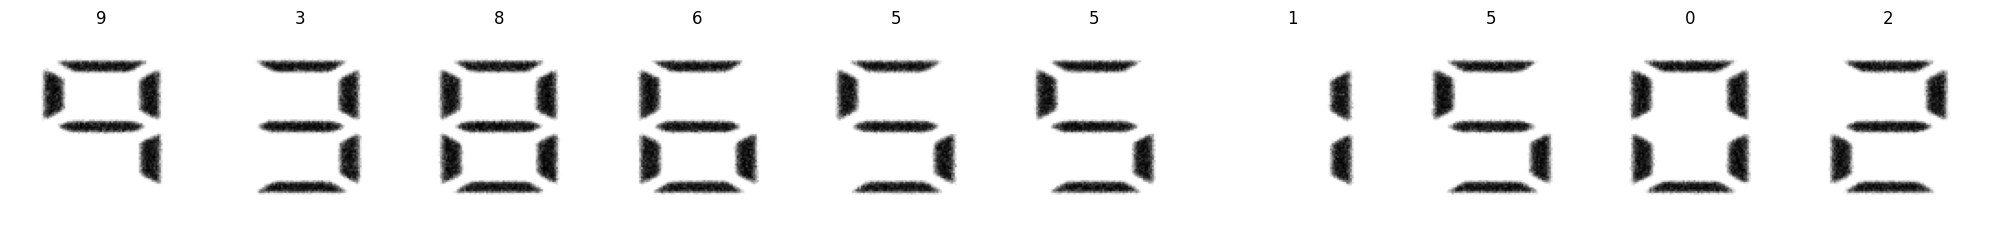

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(dataset_path, num_samples=10):
    data = np.load(dataset_path, allow_pickle=True)
    images = data['images']
    labels = data['labels']

    # Check the number of samples available
    num_samples = min(num_samples, len(images))

    # Plot the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 3))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(str(labels[i]))  # Show label as title
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
dataset_file = "mnist_style_dataset.npz"
show_samples(dataset_file, num_samples=10)



Training the model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

X, Y = 100, 100

# Custom Dataset Class
class CustomMNISTDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        # Load data from .npz file
        data = np.load(npz_file, allow_pickle=True)  # Explicitly allow pickle
        self.images = data['images']  # Shape: (num_samples, height, width)
        self.labels = data['labels']  # Shape: (num_samples,)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = int(self.labels[idx])  # Ensure labels are integers

        # Apply transformation if specified
        if self.transform:
            image = self.transform(image)

        return image, label


# Transformation Pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),                # Convert NumPy array to PIL image
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((Y, X)),            # Resize to MNIST size
    transforms.ToTensor(),                  # Convert to tensor and normalize to [0, 1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize to mean=0.5, std=0.5
])

# Load Custom Dataset
npz_file_path = "mnist_style_dataset.npz"  # Replace with your dataset file
custom_dataset = CustomMNISTDataset(npz_file=npz_file_path, transform=transform)

# Split Dataset into Training and Testing
train_size = int(0.8 * len(custom_dataset))  # 80% for training
test_size = len(custom_dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(Y*X, 10)  # 28*28 input features, 10 output classes

    def forward(self, x):
        x = x.view(-1, Y*X)  # Flatten the image
        return self.linear(x)


# Initialize Model, Loss, and Optimizer
model = LogisticRegressionModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


# Prediction Example
image, label = test_dataset[0]  # Get a test sample
image = image.unsqueeze(0)  # Add batch dimension

model.eval()
output = model(image)
probabilities = torch.softmax(output, dim=1)

print(f"True Label: {label}")
print(f"Predicted Digit: {probabilities.argmax().item()}")
print(f"Probabilities: {probabilities}")

Epoch 1, Loss: 0.6455
Epoch 2, Loss: 0.3467
Epoch 3, Loss: 0.1764
Epoch 4, Loss: 0.1418
Epoch 5, Loss: 0.1078
Epoch 6, Loss: 0.0895
Epoch 7, Loss: 0.0784
Epoch 8, Loss: 0.0657
Epoch 9, Loss: 0.0559
Epoch 10, Loss: 0.0466
Test Accuracy: 100.00%
True Label: 5
Predicted Digit: 5
Probabilities: tensor([[3.9014e-04, 3.6498e-05, 1.1577e-04, 8.0596e-03, 1.1012e-03, 9.5026e-01,
         2.9373e-02, 2.0563e-04, 2.8967e-03, 7.5657e-03]],
       grad_fn=<SoftmaxBackward0>)


One more testing...

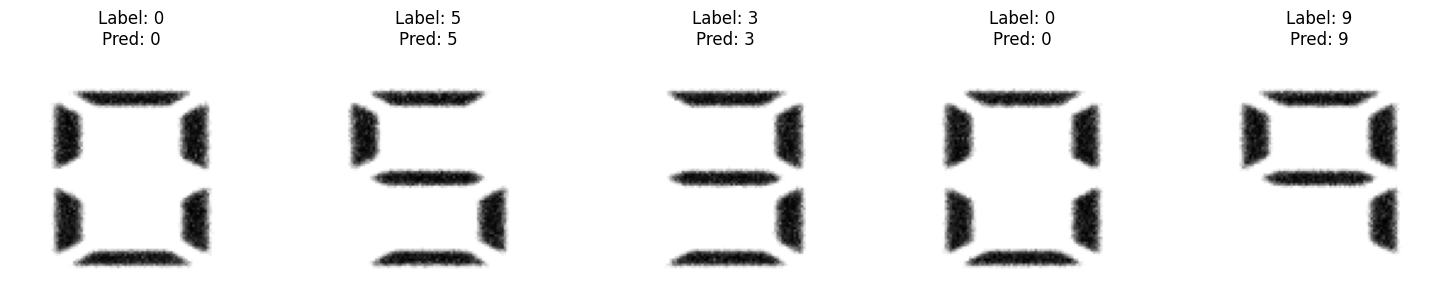

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

# Function to test the model on some samples and visualize results
def test_and_visualize_samples(model, dataset, num_samples=5):
    # Set the model to evaluation mode
    model.eval()

    # Randomly select some samples from the dataset
    indices = torch.randint(0, len(dataset), (num_samples,))
    samples = [dataset[i] for i in indices]

    # Create a figure to display the images and predictions
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i, (image, label) in enumerate(samples):
        # Prepare the image for the model
        input_tensor = image.unsqueeze(0)  # Add batch dimension

        # Predict the digit
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            predicted_digit = probabilities.argmax().item()

        # Display the image and predictions
        image_to_show = ToPILImage()(image)  # Convert tensor back to image
        axes[i].imshow(image_to_show, cmap="gray")
        axes[i].set_title(f"Label: {label}\nPred: {predicted_digit}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Test and visualize predictions
test_and_visualize_samples(model, test_dataset, num_samples=5)


## Using the model

In [ ]:
import cv2
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

# Define the Logistic Regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(Y*X, 10)  # Input: 28x28 pixels, Output: 10 classes

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

# Preprocessing function for OpenCV image
def preprocess_opencv_image(image):
    """
    Preprocess an OpenCV image for the PyTorch model.

    Args:
        image (numpy.ndarray): The input image in OpenCV format (BGR or grayscale).

    Returns:
        torch.Tensor: Preprocessed image tensor ready for the model.
    """
    # Ensure the image is grayscale
    # if len(image.shape) == 3:  # If the image has 3 channels (BGR)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image to 28x28

    img_resized = cv2.resize(image, (Y, X), interpolation=cv2.INTER_AREA)
    img_blured = cv2.GaussianBlur(image, (13, 13), 0)
    # img_noised = add_noise(image)
    # img_gray = cv2.cvtColor(img_noised, cv2.COLOR_RGB2GRAY)
    # img_resized = cv2.resize(image_nosied, image_size, interpolation=cv2.INTER_AREA)

    resized_image = cv2.resize(img_blured, (Y, X), interpolation=cv2.INTER_AREA)

    cv2_imshow(resized_image)

    # Normalize the image (scale pixel values to [0, 1], then normalize to mean=0.5, std=0.5)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
        transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
    ])

    # Apply the transformation
    tensor_image = transform(resized_image)

    # Add a batch dimension
    return tensor_image.unsqueeze(0)

# Function to make predictions
def predict_digit(image_tensor, model):
    """
    Predict the digit using the trained model.

    Args:
        image_tensor (torch.Tensor): Preprocessed image tensor.
        model (nn.Module): Trained PyTorch model.

    Returns:
        int: Predicted digit.
        torch.Tensor: Probabilities for each class.
    """
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
        probabilities = torch.softmax(output, dim=1)  # Get probabilities
        predicted_digit = probabilities.argmax().item()  # Get the most likely digit
    return predicted_digit, probabilities

# Load and preprocess the OpenCV image
opencv_image = indicator_1 #the variable will be initialized later...
input_tensor = preprocess_opencv_image(opencv_image)

# Predict the digit
predicted_digit, probabilities = predict_digit(input_tensor, model)

# Output the result
print(f"Predicted Digit: {predicted_digit}")
print(f"Probabilities: {probabilities}")
